First, call these scripts to download the genomes and prepare some taxonomic information:

/workdir/hdd29/theRefseqening/src/download_ncbi_data.py
/workdir/hdd29/theRefseqening/src/process_genome_mfas.py

/workdir/hdd29/theRefseqening/src/download_taxonomy_info.py

In [1]:
#Now, we need to keep only species level genomes. 
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 

(52758, 4)


Text(0, 0.5, 'Number of Genomes')

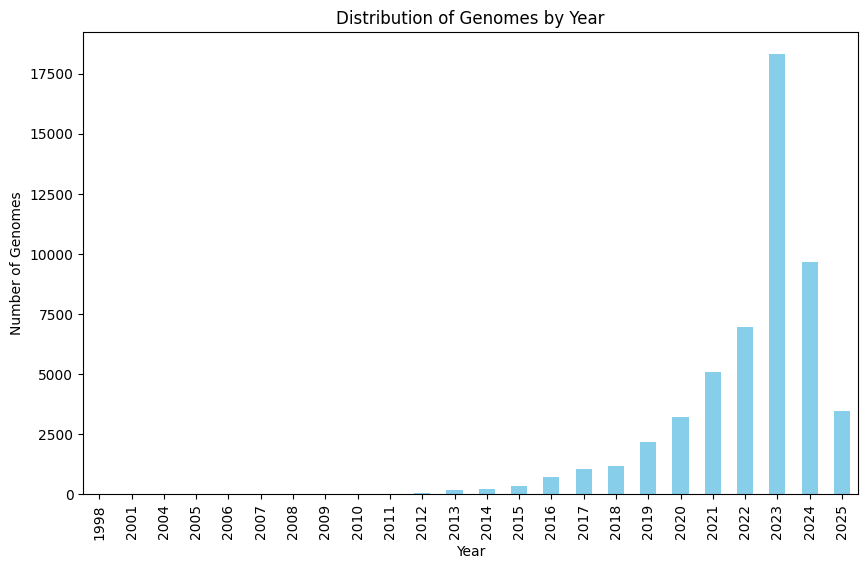

In [2]:
#read the taxonomy data, and plot the distribution of year 
tax = pd.read_csv('data/taxonomy_info.csv', index_col=0,header=0)
print(tax.shape)
#plot the distribution of year
plt.figure(figsize=(10, 6))
tax['Year'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Genomes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Genomes')

19602


Text(0, 0.5, 'Frequency')

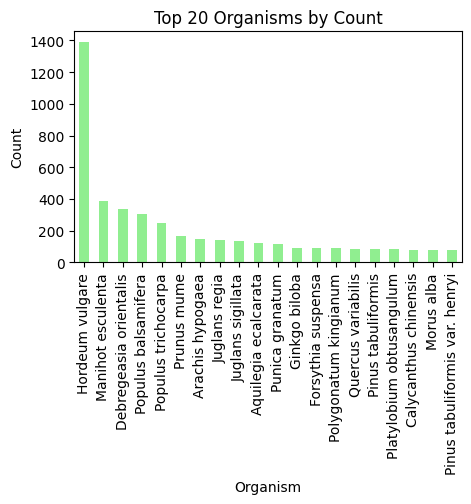

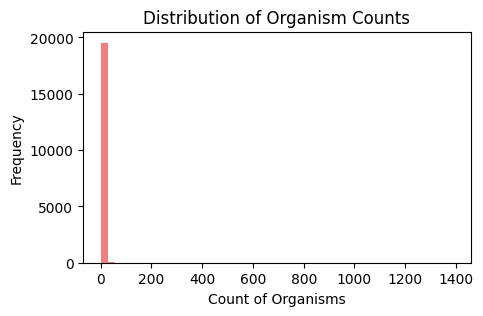

In [6]:
#how many unique Organism names are there?
print(tax['Organism'].nunique())

#what's the distribution of Organism counts?
plt.figure(figsize=(5, 3))
tax['Organism'].value_counts().sort_values(ascending=False).head(20).plot(kind='bar', color='lightgreen')
plt.title('Top 20 Organisms by Count')
plt.xlabel('Organism')
plt.ylabel('Count')

#Plot the histogram of organism counts
plt.figure(figsize=(5, 3))
tax['Organism'].value_counts().plot(kind='hist', bins=50, color='lightcoral')
plt.title('Distribution of Organism Counts')
plt.xlabel('Count of Organisms')
plt.ylabel('Frequency')

In [1]:
genome_metadata = pd.read_csv('data/taxonomy_info.csv',header=0)
print(genome_metadata.head())

def clean_species_name(name):
    """
    Remove taxonomic qualifiers and return the first two valid words.
    """
    specifiers = {"x.", "sp.", "var.", "subsp.", "f.", "spp.", "cf.", "aff.", "ex"}
    words = name.split()
    cleaned_words = [w for w in words if w.lower().strip(".") not in specifiers]
    return " ".join(cleaned_words[:2]) if len(cleaned_words) >= 2 else " ".join(cleaned_words)

def get_lui_and_species(organism_name, accession_id):
    species = clean_species_name(organism_name)
    lui = f"{accession_id}_{species.replace(' ', '')}"  # Remove space in LUI
    return lui, species

def alphanum_only(s):
    return re.sub(r'[^A-Za-z0-9]', '', s)

# Add LUI and species columns
genome_metadata["LUI"], genome_metadata["Species"] = zip(*genome_metadata.apply(
    lambda row: get_lui_and_species(row["Organism"], row["ID"]),
    axis=1
))
genome_metadata["LUI"] = genome_metadata["LUI"].apply(alphanum_only)
genome_metadata["Species"] = genome_metadata["Species"].apply(alphanum_only)

# how many unique species are there?
unique_species = genome_metadata['Species'].unique()
print(f"Number of unique species: {len(unique_species)}")

NameError: name 'pd' is not defined

In [3]:
#now, we will prepare the queries for the species occurence acquisition
# --- New code to generate args.txt ---
output_args_file = 'data/species_queries.txt' # Define the name for your arguments file
#iterate through each unique species and write the LUI and organism name to the file
unique_species = genome_metadata.drop_duplicates(subset=['Organism'])

with open(output_args_file, 'w') as f:
    for index, row in unique_species.iterrows():
        lui = row['LUI']
        organism_name = row['Organism']
        f.write(f"{lui} {organism_name}\n")
        

with open(output_args_file, 'r') as f:
    print("\nFirst 5 lines of species_queries.txt:")
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())


First 5 lines of species_queries.txt:
PV8908801Cyanotisnyctitropa Cyanotis nyctitropa
PV9487281Euonymuschloranthoides Euonymus chloranthoides
PV9629301Cardamineleucantha Cardamine leucantha
PQ6114591Polygonatumkingianum Polygonatum kingianum
PV1124521Taxussumatrana Taxus sumatrana


Run this in a protected tmux or screen session

parallel --bar --joblog parallel_jobs.log \
         --retry-failed \
         --delay 1 \
         --load 60% \
         --memfree 1G \
         --timeout 600 \
         --jobs 4 \
         ./run_occurrence_script.sh :::: data/species_queries.txt

In [ ]:
#now, we have a structure for the env_data output folder like
"""
env_data/
├── AB0861791Anthocerosangustus_Anthoceros_angustus
│   ├── Anthoceros_angustus_occurrences_clean.csv
│   ├── pirate_coords.csv
│   ├── species_metadata_bien
│   │   └── missing_species.csv
│   └── species_metadata_gbif
│       └── Anthoceros_angustus.csv
├── AB1970352Selaginellauncinata_Selaginella_uncinata
│   ├── pirate_coords.csv
│   ├── Selaginella_uncinata_occurrences_clean.csv
│   ├── species_metadata_bien
│   │   └── Selaginella_uncinata.csv
│   └── species_metadata_gbif
│       └── Selaginella_uncinata.csv
"""

#can use this one liner to combine the files into the same script
# find env_data/ -type f -name '*_clean.csv' -exec cat {} + > combined_occurrences_clean.csv

'\nenv_data/\n├── AB0861791Anthocerosangustus_Anthoceros_angustus\n│   ├── Anthoceros_angustus_occurrences_clean.csv\n│   ├── pirate_coords.csv\n│   ├── species_metadata_bien\n│   │   └── missing_species.csv\n│   └── species_metadata_gbif\n│       └── Anthoceros_angustus.csv\n├── AB1970352Selaginellauncinata_Selaginella_uncinata\n│   ├── pirate_coords.csv\n│   ├── Selaginella_uncinata_occurrences_clean.csv\n│   ├── species_metadata_bien\n│   │   └── Selaginella_uncinata.csv\n│   └── species_metadata_gbif\n│       └── Selaginella_uncinata.csv\n'